In [127]:
%pip install pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [128]:
import pandas as pd
import numpy as np  # biblioteca que suporta arrays e matrizes multidimensionais - https://numpy.org/
from sklearn import preprocessing # usado para preprocessar a base de dados (normalização)
from IPython.display import display
import ydata_profiling
from scipy import stats

import matplotlib.pyplot as plt # biblioteca para plotar gráficos
plt.rc("font", size=14)

import seaborn as sns # biblioteca de visualização de dados
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [171]:
data = pd.read_csv('mercedes-benz.csv', header=0, sep=";", index_col="id")
#exibindo dataset
data.head()

,brand,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,,
0,mercedes-benz,a 180,02-2010,d,165000,p,Automatic,7000,109
1,mercedes-benz,glk 220,02-2010,d,268000,d,Automatic,11900,170
2,mercedes-benz,c 350,07-2010,d,197000,p,Manual,11500,231
3,mercedes-benz,a 180,10-2010,d,165000,d,Manual,3200,109
4,mercedes-benz,cla 180,01-2010,l,210000,p,Manual,5500,95


In [172]:
data.shape

(16392, 9)

# About Dataset
The dataset include mercedes-benz cars for sale registered from 2000 to 2023

# About columns:

brand:manufacturer

model:version of the car

first_reg:year of the first registration of the car

fuel: d for diesel, g for gas, e for electric, l for gpl

mileage_km: mileage of the car in km

seller_type:d for dealer, p for private

shift: manual or automatic

price:the price of the car

power_hp: the power expressed in horse power of the car

In [173]:
# verificando se existem entradas nulas em algum atributo
data.isnull().sum()

brand          0
model          0
first_reg      0
fuel           0
mileage_km     0
seller_type    0
swift          0
price          0
power_hp       0
dtype: int64

In [174]:
# verificando os tipos de atributo
data.dtypes

brand          object
model          object
first_reg      object
fuel           object
mileage_km     object
seller_type    object
swift          object
price           int64
power_hp       object
dtype: object

Os atributos mileage e power deveriam ser numéricos

In [175]:
data["mileage_km"] = data["mileage_km"].astype(float)
data["power_hp"] = data["power_hp"].astype(float)

ValueError: ignored

could not convert string to float: 'unknown'

a partir deste erro, podemos ver que as entradas desconhecidas estão sendo reportadas como a string unknown e não NaN.

In [176]:
# corrigindo as strings "unknown" para NaN
data = data.replace("unknown", np.NaN)

In [177]:
# verificando novamente se existem entradas nulas em algum atributo
data.isnull().sum()

brand            0
model          120
first_reg        0
fuel             3
mileage_km       1
seller_type      0
swift            0
price            0
power_hp         0
dtype: int64

Podemos então excluir instancias com dados faltantes.

In [178]:
data = data.dropna()

In [179]:
# verificando novamente se existem entradas nulas em algum atributo
data.isnull().sum()

brand          0
model          0
first_reg      0
fuel           0
mileage_km     0
seller_type    0
swift          0
price          0
power_hp       0
dtype: int64

Com os dados tratados, podemos novamente tentar mudar o formato dos dados.

In [180]:
data["mileage_km"] = data["mileage_km"].astype(float)
data["power_hp"] = data["power_hp"].astype(float)

ValueError: ignored

Achamos mais uma entrada com dados duvidosos. uma string que não faz muito sentido na coluna power 

In [181]:
data.loc[data["power_hp"] == '">8']

,brand,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,,
68,mercedes-benz,a 160,10-2010,d,179000.0,d,Automatic,4900,""">8"


In [182]:
# buscando e eliminando instancias não numéricas
mask = data['power_hp'].str.isdecimal()
for i in data.index :
  if not mask[i]:
    data.drop(i, inplace=True)

Tentando novamente mudar o formato dos dados

In [183]:
data["mileage_km"] = data["mileage_km"].astype(float)
data["power_hp"] = data["power_hp"].astype(float)

In [184]:
# verificando os tipos de atributo
data.dtypes

brand           object
model           object
first_reg       object
fuel            object
mileage_km     float64
seller_type     object
swift           object
price            int64
power_hp       float64
dtype: object

In [185]:
# estudando atributos para redução de dados
print(data.nunique())
data["brand"].unique()

brand             1
model           184
first_reg       160
fuel              8
mileage_km     6110
seller_type       2
swift             2
price          1694
power_hp        182
dtype: int64


array(['mercedes-benz'], dtype=object)

Podemos observar que a marca possui somente entradas identicas (pois todos os carros são mercedes). Logo, podemos ignorar esta feature.

In [186]:
# removendo a feature "marca"
data = data.drop('brand', axis=1)

In [187]:
# estudando atributos para redução de dados
print(data.nunique())
data["fuel"].unique()

model           184
first_reg       160
fuel              8
mileage_km     6110
seller_type       2
swift             2
price          1694
power_hp        182
dtype: int64


array(['d', 'l', '2', 'b', 'c', '3', 'o', 'e'], dtype=object)

percebemos que as opções de combustível estão bem fora do que foi descrito no dataset. Entretanto, conseguimos recuperar esses dados e resignificá-los, pois temos os modelos de cada carro. podemos posteriormente consultar o site do fabricante e observar as opções de combustível para um modelo.

## Outra melhoria importante seria transformar a data de registro do carro de um dado categógiro para ordinal.

In [188]:
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Com a ferramenta de data profiling, prodemos ver que o preço está bem assimétrico e com valores extremos, isso atrapalha a visuialização dos histogramas, teremos que remover os outliers.

Outro fator importante é a correlação das features, principalmente com o preço. é possivel ver que a quilometragem afeta muito negativamente o preço, enquanto a força afeta positivamente.

# Destacando outliers pelo método dos quartis

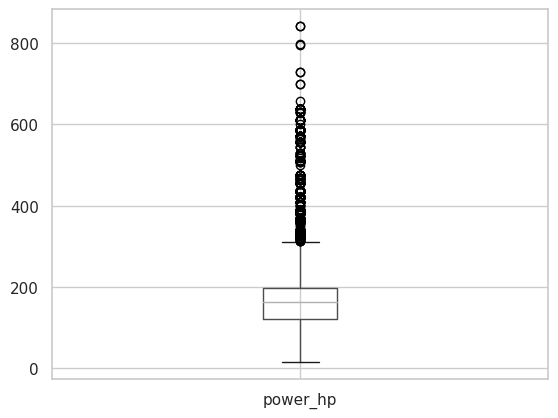

In [189]:
# destacando outliers pelo método dos quartis
boxplot = data.boxplot(column = ["power_hp"])

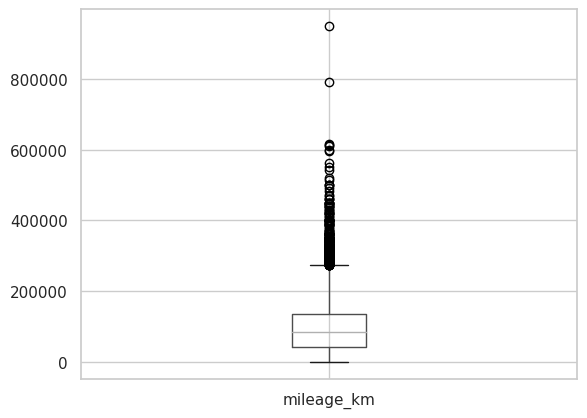

In [190]:
boxplot = data.boxplot(column = ["mileage_km"])

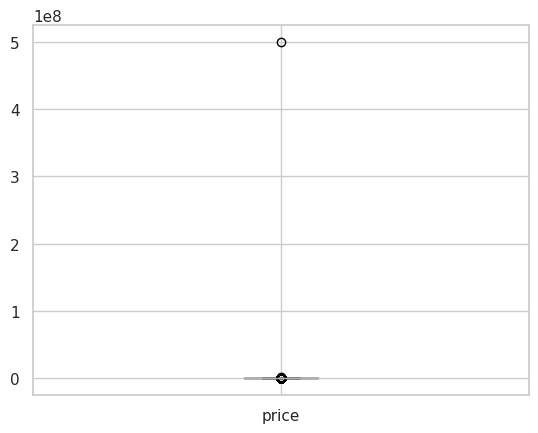

In [191]:
boxplot = data.boxplot(column = ["price"])

In [192]:
# força
powerQ1, powerQ2, powerQ3 = np.percentile(data["power_hp"], [25, 50, 75])
powerIQR = powerQ3 - powerQ1
print("Força")
print("Q1: ", powerQ1)
print("Q2: ", powerQ2)
print("Q3: ", powerQ3)
print("IQR: ", powerIQR)
powerSupLim = powerQ3 + 1.5 * powerIQR
powerInfLim = powerQ1 - 1.5 * powerIQR
print("Limite superior: ", powerSupLim)
print("Limite inferior: ", powerInfLim)


Força
Q1:  121.0
Q2:  163.0
Q3:  197.0
IQR:  76.0
Limite superior:  311.0
Limite inferior:  7.0


In [193]:
# observando instancias caracterizadas como outliers
print("outliers Superiores")
powerSupOut = data.loc[data["power_hp"] > powerSupLim]
display(powerSupOut)
print("outliers Inferiores")
powerInfOut = data.loc[data["power_hp"] < powerInfLim]
display(powerInfOut)


outliers Superiores


,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,
96,s 450,01-2010,b,270000.0,p,Manual,20000,340.0
129,cl,04-2010,b,150000.0,p,Automatic,22500,387.0
134,cl,07-2010,b,221100.0,p,Manual,19900,517.0
171,gl 500,11-2010,b,181000.0,p,Manual,30000,387.0
190,sl 350,06-2010,b,46000.0,d,Manual,46900,315.0
...,...,...,...,...,...,...,...,...
16321,g 400,09-2022,d,15000.0,d,Automatic,190000,330.0
16322,gle 400,01-2022,d,14008.0,d,Automatic,94690,330.0
16323,gle 400,01-2022,d,14008.0,d,Automatic,94690,330.0


outliers Inferiores


,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,


In [194]:
# quilometragem
kmQ1, kmQ2, kmQ3 = np.percentile(data["mileage_km"], [25, 50, 75])
kmIQR = kmQ3 - kmQ1
print("Quilometragem")
print("Q1: ", kmQ1)
print("Q2: ", kmQ2)
print("Q3: ", kmQ3)
print("IQR: ", kmIQR)
kmSupLim = kmQ3 + 1.5 * kmIQR
kmInfLim = kmQ1 - 1.5 * kmIQR
print("Limite superior: ", kmSupLim)
print("Limite inferior: ", kmInfLim)

Quilometragem
Q1:  41750.0
Q2:  85000.0
Q3:  135000.0
IQR:  93250.0
Limite superior:  274875.0
Limite inferior:  -98125.0


In [195]:
# observando instancias caracterizadas como outliers
print("outliers Superiores")
kmSupOut = data.loc[data["mileage_km"] > kmSupLim]
display(kmSupOut)
print("outliers Inferiores")
kmInfLim = 0
kmInfOut = data.loc[data["mileage_km"] < kmInfLim]
display(kmInfOut)


outliers Superiores


,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,
11,s 400,06-2010,2,309000.0,p,Manual,13900,279.0
32,e 250,10-2010,d,300000.0,p,Manual,8000,204.0
59,c 200,02-2010,d,310000.0,p,Automatic,6500,136.0
73,e 200,06-2010,d,616000.0,p,Automatic,7800,136.0
74,e 250,11-2010,d,275000.0,d,Manual,8000,204.0
...,...,...,...,...,...,...,...,...
11518,v 300,08-2019,d,360000.0,p,Manual,47000,239.0
11532,v 250,02-2019,d,309000.0,d,Automatic,38900,190.0
11606,vito,01-2019,d,370000.0,p,Manual,17700,136.0


outliers Inferiores


,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,


vale ressaltar que não é aceitavel uma quilometragem negativa, logo kmInfLim = 0

In [196]:
# preço
priceQ1, priceQ2, priceQ3 = np.percentile(data["price"], [25, 50, 75])
priceIQR = priceQ3 - priceQ1
print("Preço")
print("Q1: ", priceQ1)
print("Q2: ", priceQ2)
print("Q3: ", priceQ3)
print("IQR: ", priceIQR)
priceSupLim = priceQ3 + 1.5 * priceIQR
priceInfLim = priceQ1 - 1.5 * priceIQR
print("Limite superior: ", priceSupLim)
print("Limite inferior: ", priceInfLim)


Preço
Q1:  19500.0
Q2:  28800.0
Q3:  41500.0
IQR:  22000.0
Limite superior:  74500.0
Limite inferior:  -13500.0


Novamente, não é aceitavel um preço negativo.

In [197]:
# observando instancias caracterizadas como outliers
print("outliers Superiores")
priceSupOut = data.loc[data["price"] > priceSupLim]
display(priceSupOut)
print("outliers Inferiores")
priceInfLim = 0
priceInfOut = data.loc[data["price"] < priceInfLim]
display(priceInfOut)

outliers Superiores


,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,
234,sls,05-2010,b,4000.0,d,Manual,278000,571.0
239,sls,06-2010,b,58100.0,d,Automatic,245000,571.0
241,sls,09-2010,b,17000.0,d,Automatic,272500,571.0
245,cl,07-2010,b,122000.0,p,Manual,95000,612.0
477,g 350,07-2011,d,75000.0,d,Automatic,175000,211.0
...,...,...,...,...,...,...,...,...
16375,v 300,02-2023,d,10.0,d,Automatic,90500,235.0
16376,v 250,04-2023,d,10.0,d,Automatic,93500,190.0
16377,v 250,04-2023,d,10.0,d,Automatic,78700,190.0


outliers Inferiores


,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,


# Destacando outliers pelo método z-score com corte = 3 * desvio padrão

In [198]:
# força
zPower = stats.zscore(data["power_hp"])
zPower.describe()

count    1.595900e+04
mean     1.068552e-16
std      1.000031e+00
min     -1.976449e+00
25%     -6.966487e-01
50%     -1.895581e-01
75%      2.209438e-01
max      8.020481e+00
Name: power_hp, dtype: float64

In [199]:
outIndex = []
for i in zPower.index:
  if zPower[i]>3.0 or zPower[i]<-3.0:
    outIndex.append(i)
print(len(outIndex))
data.drop(outIndex, inplace=True)

396


<AxesSubplot: >

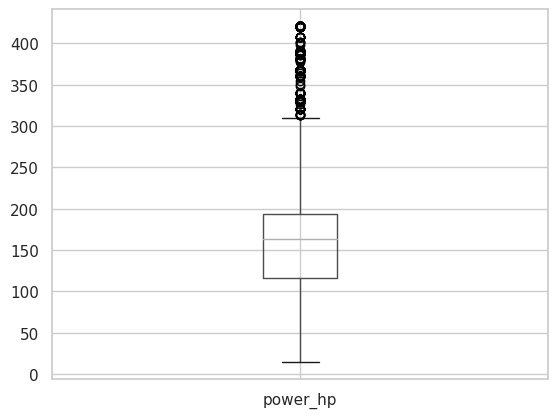

In [200]:
data.boxplot(column = ["power_hp"])

<AxesSubplot: ylabel='Frequency'>

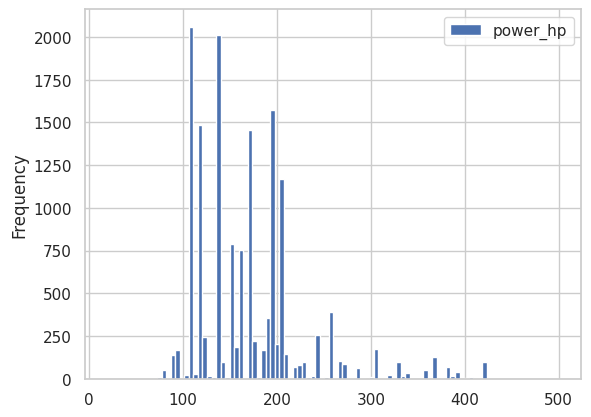

In [219]:
data.plot.hist(column=["power_hp"], bins=100, range=[20, 500])

Vale destacar que é possivel a existência dos valores acima do limite superior

In [201]:
# quilometragem
zKm = stats.zscore(data["mileage_km"])
zKm.describe()

count    1.556300e+04
mean    -5.843955e-17
std      1.000032e+00
min     -1.380470e+00
25%     -7.726804e-01
50%     -1.636321e-01
75%      5.438316e-01
max      1.206134e+01
Name: mileage_km, dtype: float64

In [202]:
outIndex = []
for i in zKm.index:
  if zKm[i]>3.0 or zKm[i]<-3.0:
    outIndex.append(i)
print(len(outIndex))
data.drop(outIndex, inplace=True)

184


<AxesSubplot: >

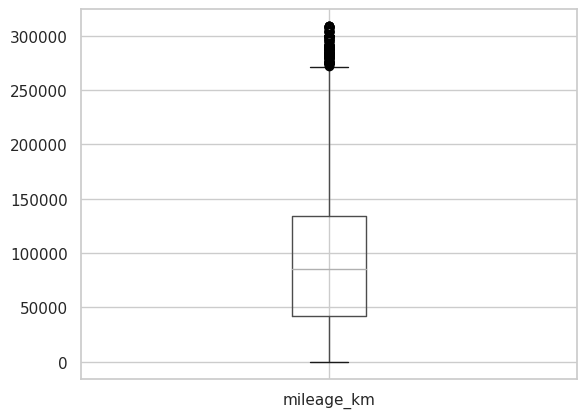

In [203]:
data.boxplot(column = ["mileage_km"])

<AxesSubplot: ylabel='Frequency'>

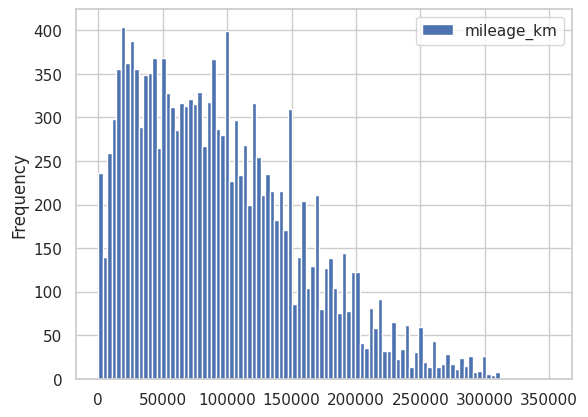

In [216]:
data.plot.hist(column=["mileage_km"], bins=100)

In [204]:
# preço
zPrice = stats.zscore(data["price"])
zPrice.describe()

count    1.537900e+04
mean    -2.310107e-18
std      1.000033e+00
min     -1.601389e-02
25%     -1.117725e-02
50%     -8.944845e-03
75%     -6.092322e-03
max      1.240067e+02
Name: price, dtype: float64

In [205]:
outIndex = []
for i in zPrice.index:
  if zPrice[i]>3.0 or zPrice[i]<-3.0:
    outIndex.append(i)
print(len(outIndex))
data.drop(outIndex, inplace=True)

1


<AxesSubplot: >

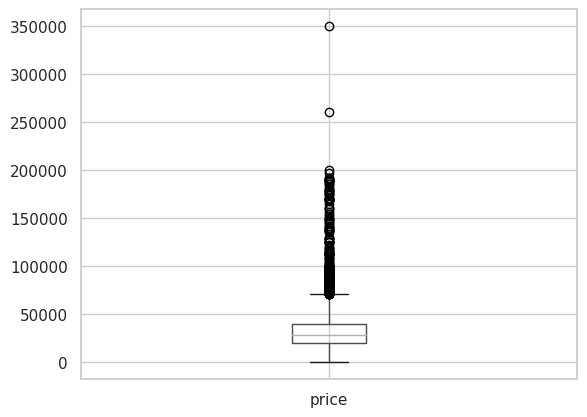

In [206]:
data.boxplot(column = ["price"])

<AxesSubplot: ylabel='Frequency'>

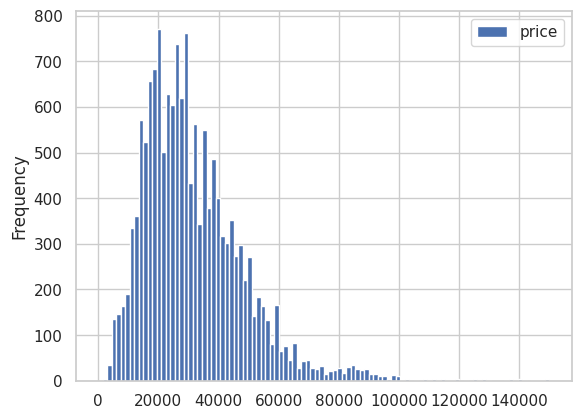

In [215]:
data.plot.hist(column=["price"], bins=100, range=[0, 150000])

Além disso, podemos observar no relatório gerado que existe uma entrada com Preço 1... claramente ela precisa ser removida

In [207]:
data.loc[data["price"] == 1]

,model,first_reg,fuel,mileage_km,seller_type,swift,price,power_hp
id,,,,,,,,
4765,cls 250,03-2016,d,200000.0,p,Manual,1,204.0


In [208]:
data.drop(4765, inplace=True)

# Gerando novamente a documentação do dataset sem os outliers

In [209]:
data.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]